In [ ]:
## Setup

# utilities
from pathlib import Path
import time
import random
# computing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# ml
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
# scikit-learn utils
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# load inertial signals
!unzip -o "UCI_HAR_Dataset[1].zip"
data_directory = Path("UCI HAR Dataset")
def load_inertial(split):
    """
    create the correctly structured input sensor X with dimensions N (num windows), T (num time steps per window), C (num sensor channels)
    for our nn to learn from
    and load subject IDs to enforce subject-disjoing splits

    load the inertial sensor time-series windows for a given split (train or test),
    combine individual sensor channels into a single tensor of shape (num_windows, time_stpes, num_channels)
    and return corresponding activity labels and subject ids for learning and leakage prevention
    """
    base = data_directory / split / "Inertial Signals"
    # list sensor channel names
    names = [
        "body_acc_x_", "body_acc_y_", "body_acc_z_",
        "body_gyro_x_", "body_gyro_y_", "body_gyro_z_",
        "total_acc_x_", "total_acc_y_", "total_acc_z_"
    ]
    # empty list to store signals
    signals = []
    # loop over each channel
    for name in names:
        # load one signal file
        arr = np.loadtxt(base / f"{name}{split}.txt")  # loads matrix of shape (N, T), N is windows T is time steps
        # ^each row one window, each column one step
        # add channel dimension: arr is (N,T) but we need tensor of (N, T, C) so we add third dimension (N, T, 1)
        signals.append(arr[:, :, None])
    # combine all chanels into one tensor: 9 arrays of shape (N, T, 1) --> one array of shape (N, T, 9)
    X = np.concatenate(signals, axis=2)  # (N, T, C=9); now have X[window, time, channel]
    # load activity labels. Currently have 1-6 but pytorch requires 0-5 so subtract 1
    y = np.loadtxt(data_directory / split / f"y_{split}.txt").astype(int) - 1  # 0..5
    # load subject IDs for each window
    subjects = np.loadtxt(data_directory / split / f"subject_{split}.txt").astype(int)

    return X, y, subjects

# get input data, activity labels, and subject ids for both sets
X_train, y_train, subj_train = load_inertial("train")
X_test,  y_test,  subj_test  = load_inertial("test") # ground truth labels hold activity label for each window as integers 0-5

# remove duplicates- each subject generates many windows, so get the unique ids that appear in each set
train_subjects = set(subj_train)
test_subjects = set(subj_test)

# check train and test are disjoint:
train_test_overlap = train_subjects & test_subjects
print("Is there any train test overlap?", "no" if len(train_test_overlap)==0 else "yes")

Archive:  UCI_HAR_Dataset[1].zip
   creating: UCI HAR Dataset/
  inflating: UCI HAR Dataset/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/UCI HAR Dataset/
  inflating: __MACOSX/UCI HAR Dataset/._.DS_Store  
  inflating: UCI HAR Dataset/activity_labels.txt  
  inflating: __MACOSX/UCI HAR Dataset/._activity_labels.txt  
  inflating: UCI HAR Dataset/features.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features.txt  
  inflating: UCI HAR Dataset/features_info.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features_info.txt  
  inflating: UCI HAR Dataset/README.txt  
  inflating: __MACOSX/UCI HAR Dataset/._README.txt  
   creating: UCI HAR Dataset/test/
   creating: UCI HAR Dataset/test/Inertial Signals/
  inflating: UCI HAR Dataset/test/Inertial Signals/body_acc_x_test.txt  
   creating: __MACOSX/UCI HAR Dataset/test/
   creating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/
  inflating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/._body_acc_x_test.txt  
  inflating: UCI 

7.

In [ ]:
## 7. training curves + reproducibility

def set_seeds(seed=42): # use 42 by default
    # set seed for each library that we use for randomness:
    random.seed(seed) # seeds Python's random module
    np.random.seed(seed) # seeds numpy's random generator
    torch.manual_seed(seed) # seeds PyTorch's random num generator for cpu ops
    torch.cuda.manual_seed_all(seed) # seeds pytorch's cuda rng for all gpus

set_seeds()


### subject-disjoint train/val split

# Create train/val split. Full per-subject data must be split so no subject in both train and val
# use gss to make sure subjects don't overlap between train and val
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42) # making val 20% and selected by subject, generate 1 split
train_idx, val_idx = next(gss.split(X_train, y_train, groups=subj_train))

X_tr, y_tr = X_train[train_idx], y_train[train_idx] # actual training subset
X_val, y_val = X_train[val_idx], y_train[val_idx] # actual val subset

# Flatten windows for MLP:
# Each example in X_train (N,T,C) is 2D (T,C) but MLP needs to be a 1D feature vector (D,)
  # so flatten each example (T, C) --> (T x C), making dataset (N, D) (num windows/sample, num features per sample)
X_tr_f  = X_tr.reshape(len(X_tr), -1) # final train/val/test splits
X_val_f = X_val.reshape(len(X_val), -1)
X_te_f  = X_test.reshape(len(X_test), -1)

# Standardize (fit on train only):
# Scale each feature on the train set (learn mean/std from train then apply to val/test)
scaler = StandardScaler()
X_tr_f  = scaler.fit_transform(X_tr_f)
X_val_f = scaler.transform(X_val_f)
X_te_f  = scaler.transform(X_te_f)

# set up PyTorch tensors
# Turn into PyTorch (example, label) TensorDatasets
train_ds = TensorDataset(torch.tensor(X_tr_f, dtype=torch.float32),
                         torch.tensor(y_tr, dtype=torch.long))
val_ds   = TensorDataset(torch.tensor(X_val_f, dtype=torch.float32),
                         torch.tensor(y_val, dtype=torch.long))
test_ds  = TensorDataset(torch.tensor(X_te_f, dtype=torch.float32),
                         torch.tensor(y_test, dtype=torch.long))

# create dataloaders to feed batches into the model
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True) # 128 to account for backprop and gradient expenses in training
val_loader   = DataLoader(val_ds, batch_size=256, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False)

# input dimension and class count needed to build the network
d_in = X_tr_f.shape[1] # input dimension first linear layer must accept: number of input features per example
n_classes = 6 # we have 6 activities, 0-5

# MLP builder so we can create and fix overfitting
# neural network with input d_in and output vector of logits/scores length n_classes
class MLP(nn.Module):
    # large --> medium --> small layer sizes
    def __init__(self, d_in, n_classes, hidden1=256, hidden2=128, dropout=0.0):
        super().__init__()
        # run these layers in order:
        self.net = nn.Sequential(
            nn.Linear(d_in, hidden1), # fully connected layer, takes input vector x of len d_in and produces new vector len hidden1
            nn.ReLU(), # activation, keeps positive vals and maps negative vals to 0, introduces nonlinearity so model can be more complex
            nn.Dropout(dropout), # regularization method that randomly sets some activations to zero/turns off some neurons to remove overreliance on specific pathways
            nn.Linear(hidden1, hidden2), # h2 = Wh1 + b
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden2, n_classes) # final layer outputs logits, just raw scores
        )

    # when x comes in, pass it through self.net (push it through the network) and return the result (output predictions)
    def forward(self, x):
        return self.net(x)

# train/eval loop that records loss + accuracy curves
def evaluate(model, loader, loss_fn):
    # function to measure model on val/test data
    model.eval() # turns off dropout
    # track total loss, predictions, and true labels
    total_loss = 0.0
    all_preds, all_true = [], []

    with torch.no_grad(): # don't track gradients since not training, speeds up
        # for each input batch and batch of correct labels:
        for xb, yb in loader:
            logits = model(xb) # model output scores
            # get average loss per sample across the batch
            loss = loss_fn(logits, yb) # will be using cross entropy loss, logits --> softmax, compare with true labels
            # running sum of total losses over all batches in the dataset
            total_loss += loss.item() * len(xb)
            # get predicted class label from logits
            preds = torch.argmax(logits, dim=1)
            # converty PyTorch tensors into NumPy arrays
            all_preds.append(preds.numpy())
            all_true.append(yb.numpy())

    # join predictions for each batch into one array of predictions for every example in dataset
    y_pred = np.concatenate(all_preds)
    # join true vals for each batch into one array
    y_true = np.concatenate(all_true)
    # average loss per example in entire dataset
    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(y_true, y_pred)
    return avg_loss, acc

def train_model(model, train_loader, val_loader, epochs, lr, dropout,
                weight_decay, clip_norm=None, early_stop_patience=None):
    """
    train nn for serveral epochs, evaluates each on validation, records training curves (loss/accuracy),
    and returns best validation accuracy and which epoch it happened

    inputs: MLP model, train_loader dataloader, val_loader dataloader, epochs, learning rate, dropout (for MLP),
    weight decay (L2 regularization strength?), clip_norm = None to prevent exploding gradients, early stopping?
    """
    loss_fn = nn.CrossEntropyLoss() # to convert multi-class classification logits into probs and produce a single loss value
    # using Adam optimizer, sufficient default
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # history tracking for curves: dictionary of lists to store metrics for each epoch
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    # variables to track best model
    best_val_acc = -1.0 # best validation accuracy
    best_epoch = 0 # which epoch got the best score
    best_state = None # model weights at that epoch
    no_improve = 0 # how many epochs in a row did not improve (for early stopping)

    # train the model for [epochs] passes
    for epoch in range(1, epochs + 1):
        # set model to training mode
        model.train()
        # initialize
        total_loss = 0.0
        all_preds, all_true = [], []
        # loop over training batches
        for xb, yb in train_loader:
            optimizer.zero_grad() # clear old gradients
            logits = model(xb) # forward pass
            loss = loss_fn(logits, yb) # compute loss
            loss.backward() # backprop
            # optional gradient clipping for when gradients get extremelyu large like for 9. instability debug
            if clip_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_norm)
            # learning step: Adam uses the gradients computed by backprop to update the weights
            optimizer.step()
            # accumulate total loss for the epoch
            total_loss += loss.item() * len(xb)
            # get predicted class labels
            preds = torch.argmax(logits, dim=1)
            # store preds and true labels
            all_preds.append(preds.detach().numpy())
            all_true.append(yb.detach().numpy())
        # compute training loss for the epoch
        train_loss = total_loss / len(train_loader.dataset)
        # compute training accuracy for the epoch
        train_acc = accuracy_score(np.concatenate(all_true), np.concatenate(all_preds))
        # evaluate on val
        val_loss, val_acc = evaluate(model, val_loader, loss_fn)
        # save metrics to history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # track best validation epoch for log:
        # if current val_acc better than what we've seen, update best score/epoch,
        if val_acc > best_val_acc:
            best_val_acc = val_acc # update
            best_epoch = epoch # update
            # comprehension to store all model params (weights and bias) at best validation epoch
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            no_improve = 0 # reset because we just improved
        else:
            no_improve += 1 # if current val accuracy not better increment number of epochs didn't improve

        print(f"Epoch {epoch:02d} | train loss {train_loss:.4f} acc {train_acc:.3f} | val loss {val_loss:.4f} acc {val_acc:.3f}")

    if best_state is not None: # make sure training did actually improve
        model.load_state_dict(best_state) # replace model's current weights with the ones of best_state

    return history, best_val_acc, best_epoch

# plot training curves
def plot_curves(history, title="Training Curves"):
    # get epochs to plot
    epochs = range(1, len(history["train_loss"]) + 1)

    # figure 1: loss plot
    plt.figure(figsize=(7,4))
    plt.plot(epochs, history["train_loss"], label="train loss")
    plt.plot(epochs, history["val_loss"], label="val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title + " (Loss)")
    plt.legend()
    plt.show()

    # figure 2: validation loss
    plt.figure(figsize=(7,4))
    plt.plot(epochs, history["train_acc"], label="train acc")
    plt.plot(epochs, history["val_acc"], label="val acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(title + " (Accuracy)")
    plt.legend()
    plt.show()

Epoch 01 | train loss 0.4926 acc 0.809 | val loss 0.1576 acc 0.944
Epoch 02 | train loss 0.3443 acc 0.915 | val loss 0.2217 acc 0.927
Epoch 03 | train loss 0.1449 acc 0.935 | val loss 0.2197 acc 0.947
Epoch 04 | train loss 0.1145 acc 0.949 | val loss 0.1710 acc 0.951
Epoch 05 | train loss 0.0987 acc 0.952 | val loss 0.2283 acc 0.956
Epoch 06 | train loss 0.1007 acc 0.955 | val loss 0.1930 acc 0.950
Epoch 07 | train loss 0.0863 acc 0.961 | val loss 0.2452 acc 0.944
Epoch 08 | train loss 0.0861 acc 0.963 | val loss 0.2592 acc 0.937
Epoch 09 | train loss 0.0801 acc 0.966 | val loss 0.4177 acc 0.931
Epoch 10 | train loss 0.1211 acc 0.957 | val loss 0.2770 acc 0.921
Epoch 11 | train loss 0.0914 acc 0.963 | val loss 0.3635 acc 0.927
Epoch 12 | train loss 0.0761 acc 0.969 | val loss 0.2948 acc 0.951
Epoch 13 | train loss 0.0555 acc 0.976 | val loss 0.2472 acc 0.951
Epoch 14 | train loss 0.0521 acc 0.978 | val loss 0.2111 acc 0.956
Epoch 15 | train loss 0.0491 acc 0.979 | val loss 0.2447 acc 0

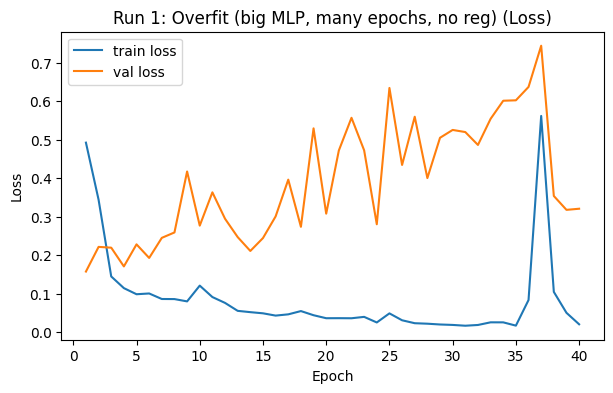

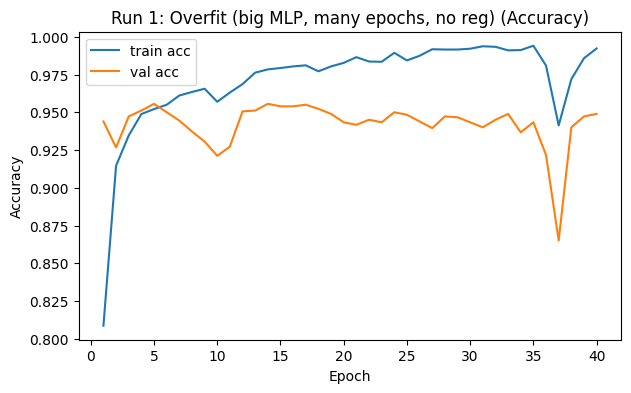

/tmp/ipython-input-227/2494005170.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([clean])], ignore_index=True)


Logged: mlp_overfit_seed123
Epoch 01 | train loss 0.5465 acc 0.790 | val loss 0.1617 acc 0.953
Epoch 02 | train loss 0.2249 acc 0.914 | val loss 0.1472 acc 0.951
Epoch 03 | train loss 0.1854 acc 0.930 | val loss 0.1666 acc 0.943
Epoch 04 | train loss 0.1386 acc 0.939 | val loss 0.2186 acc 0.944
Epoch 05 | train loss 0.1419 acc 0.938 | val loss 0.3199 acc 0.925
Epoch 06 | train loss 0.1421 acc 0.941 | val loss 0.1960 acc 0.954
Epoch 07 | train loss 0.1461 acc 0.944 | val loss 0.2007 acc 0.945
Epoch 08 | train loss 0.1795 acc 0.941 | val loss 0.3110 acc 0.929
Epoch 09 | train loss 0.1269 acc 0.945 | val loss 0.3251 acc 0.938
Epoch 10 | train loss 0.1523 acc 0.950 | val loss 0.3169 acc 0.931
Epoch 11 | train loss 0.1446 acc 0.945 | val loss 0.2311 acc 0.947
Epoch 12 | train loss 0.1178 acc 0.953 | val loss 0.2717 acc 0.941
Epoch 13 | train loss 0.1130 acc 0.954 | val loss 0.4538 acc 0.914
Epoch 14 | train loss 0.1608 acc 0.946 | val loss 0.2721 acc 0.943
Epoch 15 | train loss 0.1473 acc 0

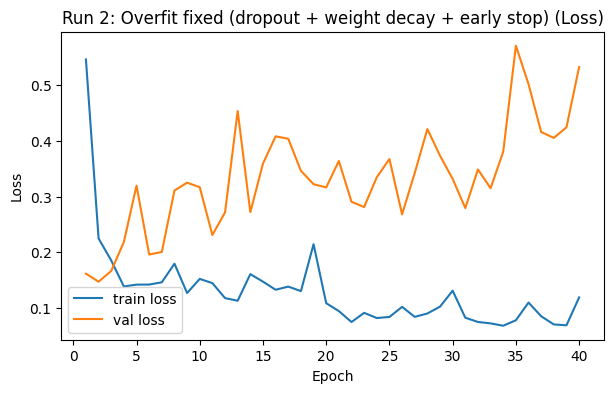

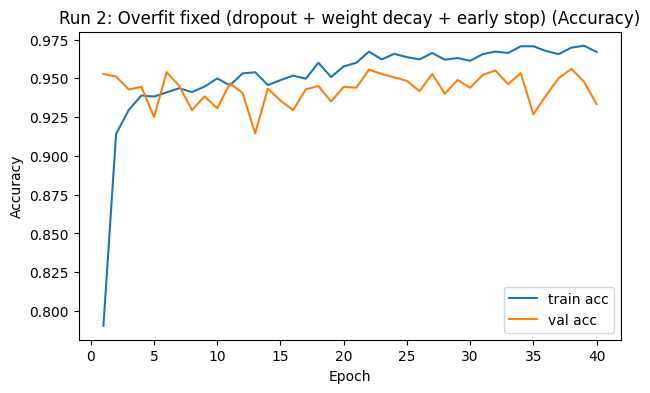

Logged: mlp_overfit_fix_seed123
Epoch 01 | train loss 41101.3821 acc 0.210 | val loss 1.8056 acc 0.184
Epoch 02 | train loss 1.8667 acc 0.184 | val loss 1.8129 acc 0.178
Epoch 03 | train loss 1.7935 acc 0.197 | val loss 1.8317 acc 0.163
Epoch 04 | train loss 1.8067 acc 0.181 | val loss 1.8032 acc 0.178
Epoch 05 | train loss 1.7991 acc 0.176 | val loss 1.8021 acc 0.163
Epoch 06 | train loss 1.8070 acc 0.178 | val loss 1.8252 acc 0.184
Epoch 07 | train loss 1.8120 acc 0.178 | val loss 1.8040 acc 0.184
Epoch 08 | train loss 1.8122 acc 0.171 | val loss 1.8275 acc 0.178
Epoch 09 | train loss 1.8059 acc 0.184 | val loss 1.8088 acc 0.188
Epoch 10 | train loss 1.8170 acc 0.179 | val loss 1.8241 acc 0.188


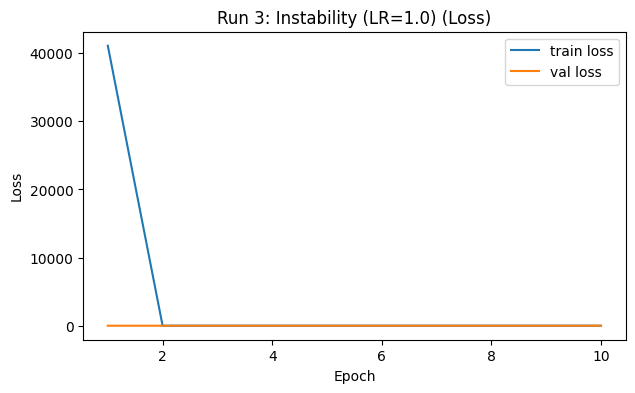

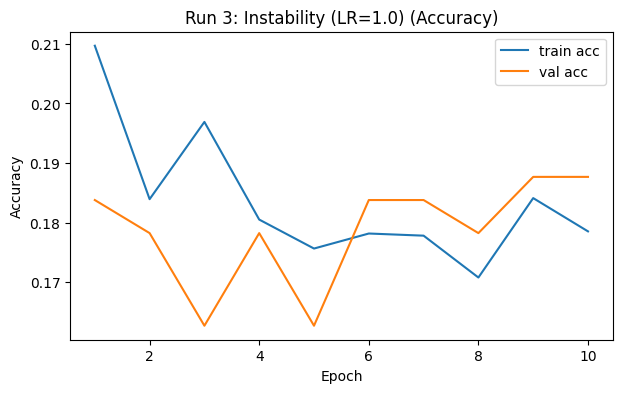

Logged: mlp_highLR_seed999
Epoch 01 | train loss 0.6886 acc 0.775 | val loss 0.2341 acc 0.923
Epoch 02 | train loss 0.1866 acc 0.927 | val loss 0.1444 acc 0.947
Epoch 03 | train loss 0.1318 acc 0.941 | val loss 0.1925 acc 0.952
Epoch 04 | train loss 0.1141 acc 0.949 | val loss 0.1381 acc 0.957
Epoch 05 | train loss 0.1069 acc 0.951 | val loss 0.1717 acc 0.956
Epoch 06 | train loss 0.0981 acc 0.957 | val loss 0.1951 acc 0.951
Epoch 07 | train loss 0.0904 acc 0.957 | val loss 0.1908 acc 0.946
Epoch 08 | train loss 0.0807 acc 0.961 | val loss 0.2233 acc 0.943
Epoch 09 | train loss 0.0801 acc 0.964 | val loss 0.1797 acc 0.946
Epoch 10 | train loss 0.0798 acc 0.964 | val loss 0.2148 acc 0.951


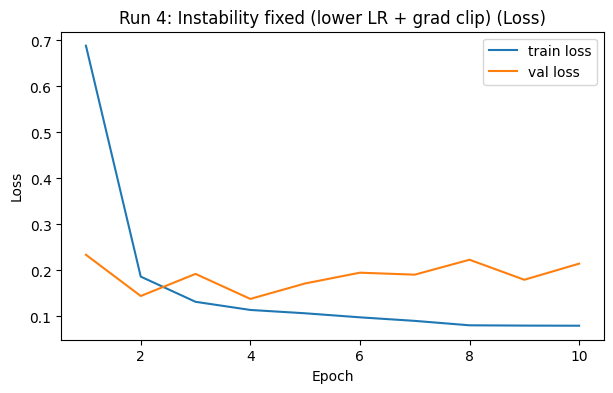

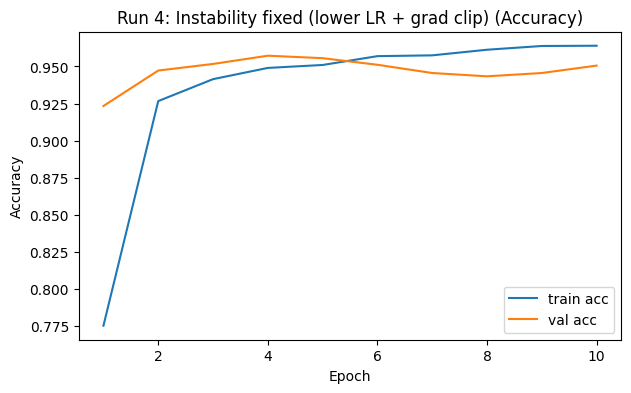

Logged: mlp_stable_seed999
Epoch 01 | train loss 0.8592 acc 0.688 | val loss 0.2804 acc 0.931
Epoch 02 | train loss 0.2819 acc 0.888 | val loss 0.1601 acc 0.954
Epoch 03 | train loss 0.1926 acc 0.923 | val loss 0.1450 acc 0.946
Epoch 04 | train loss 0.1687 acc 0.927 | val loss 0.1967 acc 0.914
Epoch 05 | train loss 0.1529 acc 0.935 | val loss 0.1549 acc 0.957
Epoch 06 | train loss 0.1392 acc 0.939 | val loss 0.1429 acc 0.961
Epoch 07 | train loss 0.1370 acc 0.940 | val loss 0.1869 acc 0.952
Epoch 08 | train loss 0.1328 acc 0.941 | val loss 0.1756 acc 0.952
Epoch 09 | train loss 0.1344 acc 0.942 | val loss 0.1329 acc 0.953
Epoch 10 | train loss 0.1293 acc 0.937 | val loss 0.1749 acc 0.956
Epoch 11 | train loss 0.1254 acc 0.947 | val loss 0.2318 acc 0.933
Epoch 12 | train loss 0.1269 acc 0.944 | val loss 0.1804 acc 0.955
Epoch 13 | train loss 0.1254 acc 0.947 | val loss 0.1518 acc 0.959
Epoch 14 | train loss 0.1177 acc 0.949 | val loss 0.1981 acc 0.959
Epoch 15 | train loss 0.1094 acc 0.

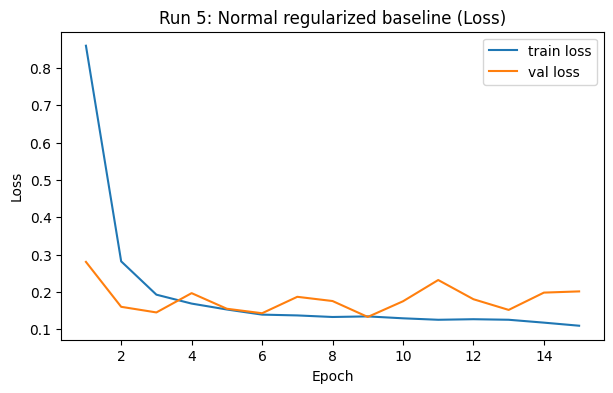

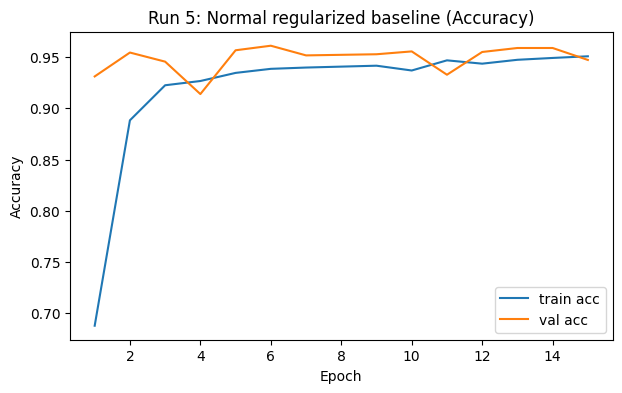

Logged: mlp_regularized_seed2026


,run_id,model,seed,optimizer,lr,batch_size,dropout,weight_decay,clip_norm,scheduler,metric_primary,metric_secondary,best_val_epoch,notes
0,mlp_overfit_seed123,mlp_flat,123,Adam,0.001,128,0.0,0.0000,NaN,NaN,0.955580,NaN,5,Intentionally overfit: oversized MLP + many ep...
1,mlp_overfit_fix_seed123,mlp_flat,123,Adam,0.001,128,0.4,0.0001,NaN,NaN,0.956135,NaN,38,Fixed overfitting with dropout + weight decay ...
2,mlp_highLR_seed999,mlp_flat,999,Adam,1.000,128,0.0,0.0000,NaN,NaN,0.187674,NaN,9,Triggered instability using extremely high lea...
3,mlp_stable_seed999,mlp_flat,999,Adam,0.001,128,0.0,0.0000,1.0,NaN,0.957246,NaN,4,Fixed instability with lower LR + gradient cli...
4,mlp_regularized_seed2026,mlp_flat,2026,Adam,0.001,128,0.3,0.0001,NaN,NaN,0.961133,NaN,6,Extra logged run to satisfy run count; regular...


In [ ]:
# -------------------------
# 10) Experiment log (exact required columns)
# -------------------------
LOG_PATH = "experiment_log_week2.csv"
COLUMNS = [
    "run_id","model","seed","optimizer","lr","batch_size","dropout","weight_decay",
    "clip_norm","scheduler","metric_primary","metric_secondary","best_val_epoch","notes"
]

def init_log():
    if not Path(LOG_PATH).exists():
        pd.DataFrame(columns=COLUMNS).to_csv(LOG_PATH, index=False)

def log_run(row):
    init_log()
    df = pd.read_csv(LOG_PATH)
    # keep only required columns
    clean = {c: row.get(c, None) for c in COLUMNS}
    df = pd.concat([df, pd.DataFrame([clean])], ignore_index=True)
    df.to_csv(LOG_PATH, index=False)
    print("Logged:", clean["run_id"])

# =========================
# RUN 1 — Intentional Overfitting
# =========================
seed = 123
set_seeds(seed)

model = MLP(d_in, n_classes, hidden1=2048, hidden2=1024, dropout=0.0)
history, best_val, best_ep = train_model(
    model, train_loader, val_loader,
    epochs=40, lr=1e-3,
    dropout=0.0, weight_decay=0.0,
    clip_norm=None, early_stop_patience=None
)
plot_curves(history, "Run 1: Overfit (big MLP, many epochs, no reg)")

log_run({
    "run_id": "mlp_overfit_seed123",
    "model": "mlp_flat",
    "seed": seed,
    "optimizer": "Adam",
    "lr": 1e-3,
    "batch_size": 128,
    "dropout": 0.0,
    "weight_decay": 0.0,
    "clip_norm": None,
    "scheduler": "None",
    "metric_primary": best_val,
    "metric_secondary": None,
    "best_val_epoch": best_ep,
    "notes": "Intentionally overfit: oversized MLP + many epochs + no regularization."
})

# =========================
# RUN 2 — Fix Overfitting (>=2 interventions)
# Interventions used: dropout + weight decay (+ optional early stopping)
# =========================
seed = 123
set_seeds(seed)

model = MLP(d_in, n_classes, hidden1=2048, hidden2=1024, dropout=0.4)
history, best_val, best_ep = train_model(
    model, train_loader, val_loader,
    epochs=40, lr=1e-3,
    dropout=0.4, weight_decay=1e-4,
    clip_norm=None, early_stop_patience=5
)
plot_curves(history, "Run 2: Overfit fixed (dropout + weight decay + early stop)")

log_run({
    "run_id": "mlp_overfit_fix_seed123",
    "model": "mlp_flat",
    "seed": seed,
    "optimizer": "Adam",
    "lr": 1e-3,
    "batch_size": 128,
    "dropout": 0.4,
    "weight_decay": 1e-4,
    "clip_norm": None,
    "scheduler": "None",
    "metric_primary": best_val,
    "metric_secondary": None,
    "best_val_epoch": best_ep,
    "notes": "Fixed overfitting with dropout + weight decay (and early stopping)."
})

# =========================
# RUN 3 — Intentional Instability
# Trigger: very high LR
# =========================
set_seeds()
# build regular size model, no dropout here to prevent noise
model = MLP(d_in, n_classes, hidden1=256, hidden2=128, dropout=0.0)
# issue: lr = 1.0 and no weight decay so no regularization to control it, no gradient clipping so we let gradietns explode
# for adam lr typically extremely small with 1e, but we set to about 1000x so each weight update step is ginagnitc
# this overshoots weights massively, leads to extreme logits --> extreme losses
# loss gets bigger --> gradients get bigger --> updates bigger --> loss explodes --> triggers NaNs
history, best_val, best_ep = train_model(
    model, train_loader, val_loader,
    epochs=10, lr=1.0,     # intentionally too high
    dropout=0.0, weight_decay=0.0,
    clip_norm=None, early_stop_patience=None
)
plot_curves(history, "Run 3: Instability (LR=1.0)")

log_run({
    "run_id": "mlp_highLR_seed999",
    "model": "mlp_flat",
    "seed": seed,
    "optimizer": "Adam",
    "lr": 1.0,
    "batch_size": 128,
    "dropout": 0.0,
    "weight_decay": 0.0,
    "clip_norm": None,
    "scheduler": "None",
    "metric_primary": best_val,
    "metric_secondary": None,
    "best_val_epoch": best_ep,
    "notes": "Triggered instability using extremely high learning rate."
})

# =========================
# RUN 4 — Fix Instability (2 interventions)
# Interventions: lower LR + gradient clipping
# =========================
set_seeds()
# rebuild simple model architecture
# intervention 1: lower lr to 1e-3 which is standard lr for adam
# intervention 2: gradient clipping which limits gradient size
# weight decay 0 still because not significant
# early stop none because stabilize instead of stopping
model = MLP(d_in, n_classes, hidden1=256, hidden2=128, dropout=0.0)
history, best_val, best_ep = train_model(
    model, train_loader, val_loader,
    epochs=10, lr=1e-3,
    dropout=0.0, weight_decay=0.0,
    clip_norm=1.0, early_stop_patience=None
)
plot_curves(history, "Run 4: Instability fixed (lower LR + grad clip)")

log_run({
    "run_id": "mlp_stable_seed999",
    "model": "mlp_flat",
    "seed": seed,
    "optimizer": "Adam",
    "lr": 1e-3,
    "batch_size": 128,
    "dropout": 0.0,
    "weight_decay": 0.0,
    "clip_norm": 1.0,
    "scheduler": "None",
    "metric_primary": best_val,
    "metric_secondary": None,
    "best_val_epoch": best_ep,
    "notes": "Fixed instability with lower LR + gradient clipping."
})

# =========================
# RUN 5 — Extra normal run (to reach 5 total runs for team requirement)
# =========================
set_seeds()

model = MLP(d_in, n_classes, hidden1=256, hidden2=128, dropout=0.3)
history, best_val, best_ep = train_model(
    model, train_loader, val_loader,
    epochs=15, lr=1e-3,
    dropout=0.3, weight_decay=1e-4,
    clip_norm=None, early_stop_patience=None
)
plot_curves(history, "Run 5: Normal regularized baseline")

log_run({
    "run_id": "mlp_regularized_seed2026",
    "model": "mlp_flat",
    "seed": seed,
    "optimizer": "Adam",
    "lr": 1e-3,
    "batch_size": 128,
    "dropout": 0.3,
    "weight_decay": 1e-4,
    "clip_norm": None,
    "scheduler": "None",
    "metric_primary": best_val,
    "metric_secondary": None,
    "best_val_epoch": best_ep,
    "notes": "Extra logged run to satisfy run count; regularized MLP."
})

# Show log
pd.read_csv(LOG_PATH)

8. Overfitting control

In [ ]:
# overfit
set_seeds(123)

overfit_model = MLP(d_in=d_in, n_classes=n_classes,
                    hidden1=2048, hidden2=1024,
                    dropout=0.0)

history_overfit, best_val_overfit = train_model(
    overfit_model,
    train_loader, val_loader,
    epochs=40,          # too many
    lr=1e-3,
    weight_decay=0.0,   # no L2
    grad_clip=None,
    lr_step_scheduler=None,
    early_stopping_patience=None
)

plot_curves(history_overfit, title="Overfit Run (big MLP, many epochs, no regularization)")

append_log({
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
    "run_name": "overfit_big_mlp",
    "seed": 123,
    "model": "MLP",
    "hidden1": 2048,
    "hidden2": 1024,
    "dropout": 0.0,
    "lr": 1e-3,
    "weight_decay": 0.0,
    "epochs_planned": 40,
    "early_stopping": "no",
    "lr_scheduler": "no",
    "grad_clip": "no",
    "best_val_acc": best_val_overfit,
    "note": "Intentionally induced overfitting: oversized MLP + too many epochs + no regularization."
})

# fit overfitting with dropout, weight decay, and early stopping
set_seeds(123)

fixed_overfit_model = MLP(d_in=d_in, n_classes=n_classes,
                          hidden1=2048, hidden2=1024,
                          dropout=0.4)  # intervention 1: dropout

history_fixed_overfit, best_val_fixed_overfit = train_model(
    fixed_overfit_model,
    train_loader, val_loader,
    epochs=40,
    lr=1e-3,
    weight_decay=1e-4,              # intervention 2: weight decay
    grad_clip=None,
    lr_step_scheduler=None,
    early_stopping_patience=5       # intervention 3: early stopping
)

plot_curves(history_fixed_overfit, title="Overfit Fix (dropout + weight decay + early stopping)")

print("Before (overfit) best val acc:", best_val_overfit)
print("After  (fixed)  best val acc:", best_val_fixed_overfit)

append_log({
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
    "run_name": "overfit_fixed_dropout_wd_es",
    "seed": 123,
    "model": "MLP",
    "hidden1": 2048,
    "hidden2": 1024,
    "dropout": 0.4,
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "epochs_planned": 40,
    "early_stopping": "patience=5",
    "lr_scheduler": "no",
    "grad_clip": "no",
    "best_val_acc": best_val_fixed_overfit,
    "note": "Fixed overfitting using dropout + weight decay + early stopping."
})

In [ ]:
# =========================
# RUN 1 — Intentional Overfitting
# =========================

# Define hyperparameters FIRST
seed = 123
# huge MLP hidden units which gives network more parameters than it needs
# memorizes on training data instead of learning general patterns
hidden1 = 2048
hidden2 = 1024
# 0 dropout means no regulization
# dropout forces the model not to reply on any single neuron too much
# so turning it off completely results in the neurons co-adapting and memorizing specific training examples
dropout = 0.0
lr = 1e-3
# usually discourages large weights and smooths the model
#  the network can push to extreme values and overfitting becomes easier with off
weight_decay = 0.0
# no gradient clipping - model can take aggressive updates and latch onto noise faster
# trains long enough to memorize and has a high learning rate which helps reach memorization faster
clip_norm = None
optimizer_name = "Adam"
scheduler_name = "None"
epochs = 40
batch_size_train = 128  # must match DataLoader

# Set seed
set_seeds(seed)

# Build model using those variables
model = MLP(
    d_in=d_in,
    n_classes=n_classes,
    hidden1=hidden1,
    hidden2=hidden2,
    dropout=dropout
)

# Train model
history, best_val_acc, best_epoch = train_model(
    model,
    train_loader,
    val_loader,
    epochs=epochs,
    lr=lr,
    optimizer_name=optimizer_name,
    weight_decay=weight_decay,
    clip_norm=clip_norm,
    scheduler_name=scheduler_name,
    scheduler_params=None,
    early_stopping_patience=None
)

# Log immediately after training
append_log({
    "run_id": f"mlp_overfit_seed{seed}",
    "model": "mlp_flat",
    "seed": seed,
    "optimizer": optimizer_name,
    "lr": lr,
    "batch_size": batch_size_train,
    "dropout": dropout,
    "weight_decay": weight_decay,
    "clip_norm": clip_norm,
    "scheduler": scheduler_name,
    "metric_primary": best_val_acc,
    "metric_secondary": None,
    "best_val_epoch": best_epoch,
    "notes": "Intentional overfitting: large MLP + no regularization."
})

In [ ]:
# =========================
# RUN 2 — Fix Overfitting
# =========================

seed = 123
hidden1 = 2048
hidden2 = 1024
# randomly disables 40% of hidden units on each forward pass
# prevents neurons from co-adapting and makes memorization harder so the model must learn generalizable features with no shortcuts
dropout = 0.4
lr = 1e-3
# weight decay patterns decouple with the AdamW optimizer allowing it to penalize larger weights and reduce sensitivity to noise
# stops early to prevent late stage memorization meaning the training stops when validation performance
# stops improving which allows the model to be locked before memorizatio
weight_decay = 1e-4
clip_norm = None
optimizer_name = "AdamW"
scheduler_name = "None"
epochs = 40
batch_size_train = 128

set_seeds(seed)

model = MLP(
    d_in=d_in,
    n_classes=n_classes,
    hidden1=hidden1,
    hidden2=hidden2,
    dropout=dropout
)

history, best_val_acc, best_epoch = train_model(
    model,
    train_loader,
    val_loader,
    epochs=epochs,
    lr=lr,
    optimizer_name=optimizer_name,
    weight_decay=weight_decay,
    clip_norm=clip_norm,
    scheduler_name=scheduler_name,
    scheduler_params=None,
    early_stopping_patience=5
)

append_log({
    "run_id": f"mlp_fix_seed{seed}",
    "model": "mlp_flat",
    "seed": seed,
    "optimizer": optimizer_name,
    "lr": lr,
    "batch_size": batch_size_train,
    "dropout": dropout,
    "weight_decay": weight_decay,
    "clip_norm": clip_norm,
    "scheduler": scheduler_name,
    "metric_primary": best_val_acc,
    "metric_secondary": None,
    "best_val_epoch": best_epoch,
    "notes": "Fixed overfitting using dropout + weight decay + early stopping."
})

9. Instability debug

In [ ]:
# intentionally trigger high NaNs from high LR
set_seeds(999)

unstable_model = MLP(d_in=d_in, n_classes=n_classes,
                     hidden1=256, hidden2=128,
                     dropout=0.0)

# High LR to intentionally destabilize
history_unstable, best_val_unstable = train_model(
    unstable_model,
    train_loader, val_loader,
    epochs=10,
    lr=1.0,                 # intentionally too high
    weight_decay=0.0,
    grad_clip=None,
    lr_step_scheduler=None,
    early_stopping_patience=None
)

plot_curves(history_unstable, title="Instability Run (LR too high)")

append_log({
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
    "run_name": "instability_high_lr",
    "seed": 999,
    "model": "MLP",
    "hidden1": 256,
    "hidden2": 128,
    "dropout": 0.0,
    "lr": 1.0,
    "weight_decay": 0.0,
    "epochs_planned": 10,
    "early_stopping": "no",
    "lr_scheduler": "no",
    "grad_clip": "no",
    "best_val_acc": best_val_unstable,
    "note": "Intentionally triggered instability with extremely high learning rate."
})

# now fix using lower LR and gradient clipping
set_seeds(999)

stable_model = MLP(d_in=d_in, n_classes=n_classes,
                   hidden1=256, hidden2=128,
                   dropout=0.0)

history_stable, best_val_stable = train_model(
    stable_model,
    train_loader, val_loader,
    epochs=10,
    lr=1e-3,                 # intervention 1: lower LR
    weight_decay=0.0,
    grad_clip=1.0,           # intervention 2: gradient clipping
    lr_step_scheduler=None,
    early_stopping_patience=None
)

plot_curves(history_stable, title="Instability Fix (lower LR + grad clipping)")

print("Before (unstable) best val acc:", best_val_unstable)
print("After  (fixed)    best val acc:", best_val_stable)

append_log({
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
    "run_name": "instability_fixed_low_lr_clip",
    "seed": 999,
    "model": "MLP",
    "hidden1": 256,
    "hidden2": 128,
    "dropout": 0.0,
    "lr": 1e-3,
    "weight_decay": 0.0,
    "epochs_planned": 10,
    "early_stopping": "no",
    "lr_scheduler": "no",
    "grad_clip": "1.0",
    "best_val_acc": best_val_stable,
    "note": "Fixed instability using lower LR + gradient clipping."
})


In [ ]:
# =========================
# RUN 3 — Instability (High LR)
# =========================

seed = 999
hidden1 = 256
hidden2 = 128
dropout = 0.0
lr = 1.0   # intentionally too high
weight_decay = 0.0
clip_norm = None
optimizer_name = "Adam"
scheduler_name = "None"
epochs = 10
batch_size_train = 128

set_seeds(seed)

model = MLP(d_in=d_in, n_classes=n_classes,
            hidden1=hidden1, hidden2=hidden2, dropout=dropout)

history, best_val_acc, best_epoch = train_model(
    model,
    train_loader,
    val_loader,
    epochs=epochs,
    lr=lr,
    optimizer_name=optimizer_name,
    weight_decay=weight_decay,
    clip_norm=clip_norm,
    scheduler_name=scheduler_name,
    scheduler_params=None,
    early_stopping_patience=None
)

append_log({
    "run_id": f"mlp_highLR_seed{seed}",
    "model": "mlp_flat",
    "seed": seed,
    "optimizer": optimizer_name,
    "lr": lr,
    "batch_size": batch_size_train,
    "dropout": dropout,
    "weight_decay": weight_decay,
    "clip_norm": clip_norm,
    "scheduler": scheduler_name,
    "metric_primary": best_val_acc,
    "metric_secondary": None,
    "best_val_epoch": best_epoch,
    "notes": "Instability triggered using extremely high learning rate."
})

10. experiment log disciple

In [ ]:
# adding a normal, baseline run to satisfy >= 5 runs in the log
set_seeds(2026)

scheduled_model = MLP(d_in=d_in, n_classes=n_classes,
                      hidden1=256, hidden2=128,
                      dropout=0.3)

history_sched, best_val_sched = train_model(
    scheduled_model,
    train_loader, val_loader,
    epochs=15,
    lr=1e-3,
    weight_decay=1e-4,
    grad_clip=None,
    lr_step_scheduler=(5, 0.5),   # StepLR: every 5 epochs lr *= 0.5
    early_stopping_patience=None
)

plot_curves(history_sched, title="Extra Run (dropout + weight decay + StepLR)")

append_log({
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
    "run_name": "extra_run_stepLR",
    "seed": 2026,
    "model": "MLP",
    "hidden1": 256,
    "hidden2": 128,
    "dropout": 0.3,
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "epochs_planned": 15,
    "early_stopping": "no",
    "lr_scheduler": "StepLR(step=5,gamma=0.5)",
    "grad_clip": "no",
    "best_val_acc": best_val_sched,
    "note": "Extra logged run to satisfy run count; demonstrates LR scheduling."
})

# show the log
pd.read_csv(LOG_PATH)